# Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
# Set the theme for figures
sns.set_theme()

In [3]:
# load the daily rainfall time series data
daily = pd.read_parquet('data/rain_time_series.parquet')

# Feature creation

Create features for year, month, day of the month, and day of the year. We will use these as features to train our model on

In [4]:
def get_features(df):
    """
    Create temporal features from time series dataframe index
    """
    df['day_of_year'] = df.index.day_of_year
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day

    return df

In [5]:
daily = get_features(daily)

In [6]:
daily.head()

,rain,day_of_year,year,month,day
2006-10-01,0,274,2006,10,1
2006-10-02,0,275,2006,10,2
2006-10-03,0,276,2006,10,3
2006-10-04,0,277,2006,10,4
2006-10-05,0,278,2006,10,5


Create a monthly rainfall total dataframe too because daily rainfall prediction might be too inaccurate and unnecessary.

In [7]:
monthly = pd.DataFrame(data=daily.groupby(['year', 'month']).agg('sum')['rain'].values, index=daily.query('day == 1').index, columns=['total_rain_mm'])

In [9]:
monthly = get_features(monthly)

In [10]:
monthly.head()

,total_rain_mm,day_of_year,year,month,day
2006-10-01,22,274,2006,10,1
2006-11-01,187,305,2006,11,1
2006-12-01,78,335,2006,12,1
2007-01-01,18,1,2007,1,1
2007-02-01,32,32,2007,2,1


# Plot the time series data

Text(0.5, 1.0, 'daily rainfall')

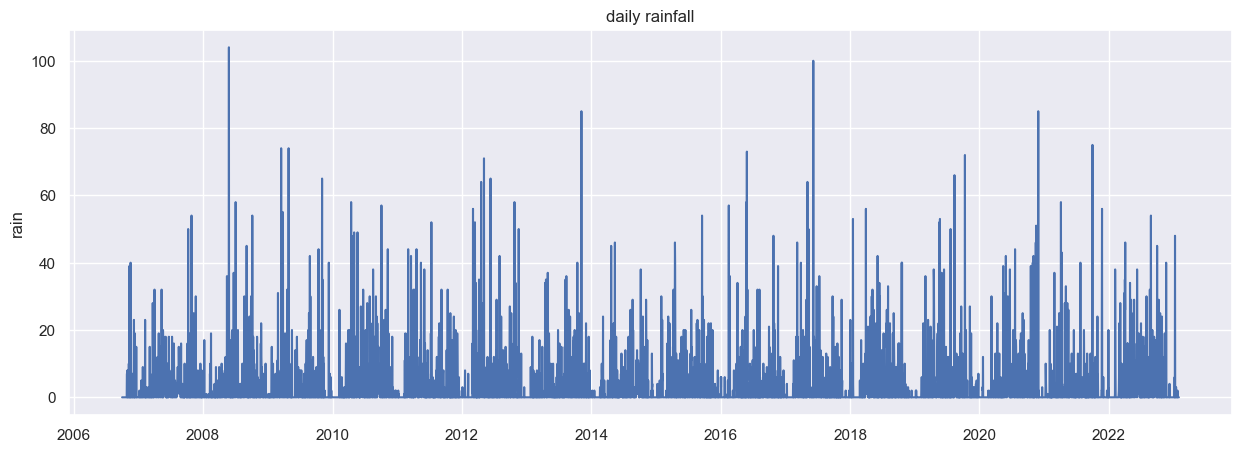

In [19]:
plt.figure(figsize=(15,5))
sns.lineplot(x=daily.index, y=daily.rain)
plt.title('daily rainfall')

Text(0.5, 1.0, 'Monthly Rainfall Totals')

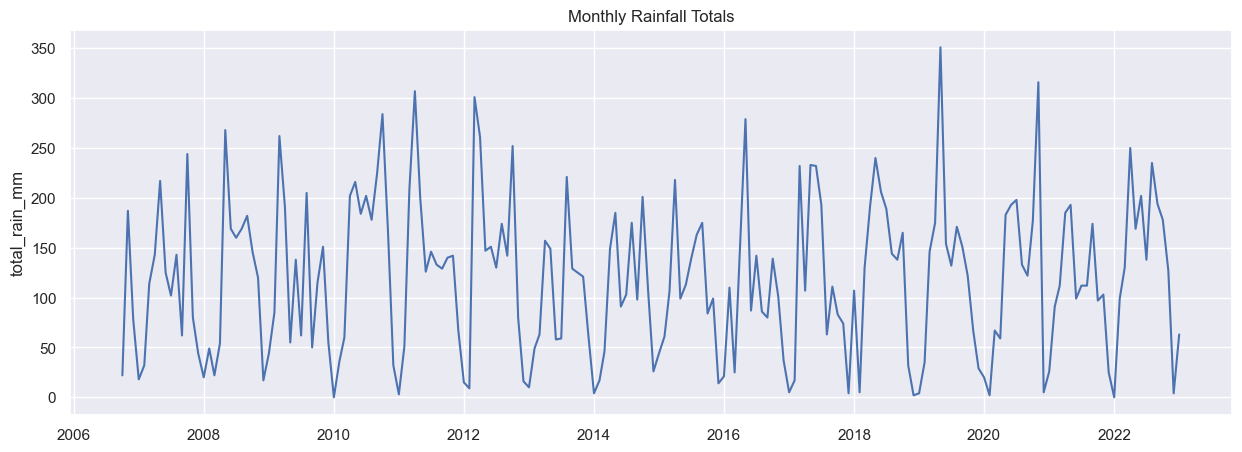

In [22]:
plt.figure(figsize=(15,5))
sns.lineplot(x=monthly.index, y=monthly.total_rain_mm)
plt.title('Monthly Rainfall Totals')

There is clearly a yearly seasonality visible in the data that I have explored elsewhere. Let's proceed with the time series model.

# Time Series Cross Fold Validation

I will perform time series cross fold validation which is different from standard cross fold validation in that the order dates needs to be preserved. I will start with 5 fold cross validation and will visualize each of the folds below. The orange points are the validation sets and the blue points are the training sets.

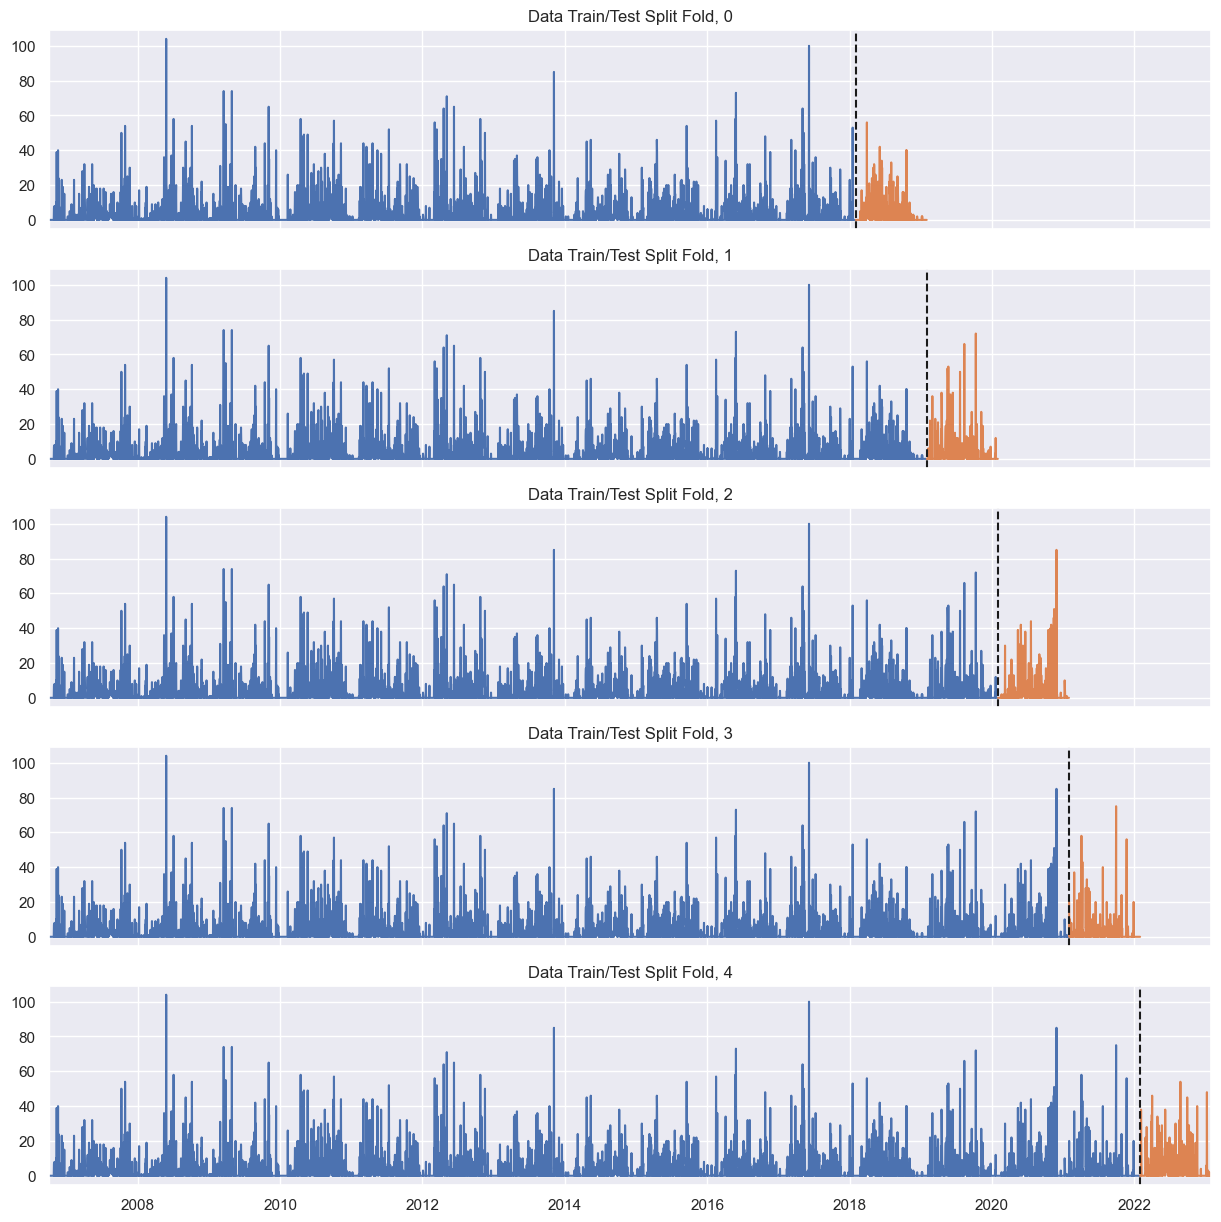

In [24]:
tss = TimeSeriesSplit(n_splits=5, test_size=365)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(daily)):
    
    train = daily.iloc[train_idx]
    test = daily.iloc[val_idx]

    train['rain'].plot(ax=axs[fold], 
                       label='Training Set',
                       title=f'Data Train/Test Split Fold, {fold}')
    test['rain'].plot(ax=axs[fold], 
                       label='Test Set')
    axs[fold].axvline(test.index.min(), color='k', ls='--')

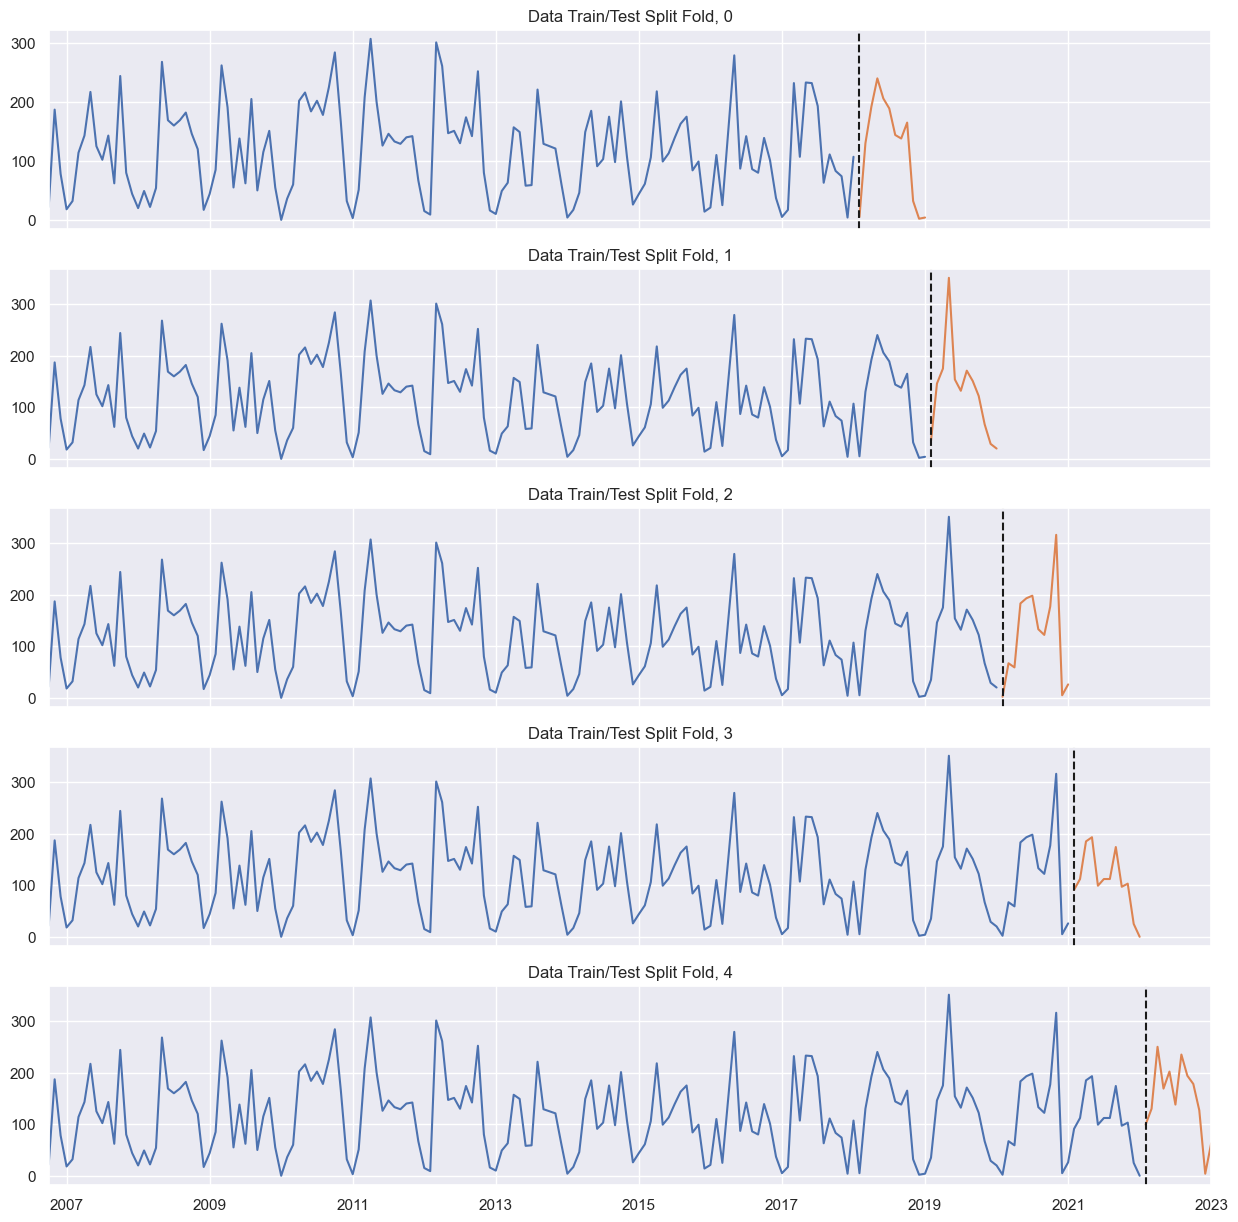

In [29]:
tss = TimeSeriesSplit(n_splits=5, test_size=12, gap=0)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(monthly)):
    
    train = monthly.iloc[train_idx]
    test = monthly.iloc[val_idx]

    train['total_rain_mm'].plot(ax=axs[fold], 
                       label='Training Set',
                       title=f'Data Train/Test Split Fold, {fold}')
    test['total_rain_mm'].plot(ax=axs[fold], 
                       label='Test Set')
    axs[fold].axvline(test.index.min(), color='k', ls='--')

In [30]:
# def get_lags(df):
#     # create a dictionary for mapping lag features
#     target_map = df['rain'].to_dict()

#     df['lag_1y'] = (df.index - pd.Timedelta('365 days')).map(target_map)
#     df['lag_2y'] = (df.index - pd.Timedelta('730 days')).map(target_map)
#     df['lag_3y'] = (df.index - pd.Timedelta('1095 days')).map(target_map)

#     df['lag_1d'] = (df.index - pd.Timedelta('1 days')).map(target_map)
#     df['lag_2d'] = (df.index - pd.Timedelta('2 days')).map(target_map)
#     df['lag_3d'] = (df.index - pd.Timedelta('3 days')).map(target_map)

#     # in order to avoid data leakage we need to calculate the mean and standard deviation window 
#     # functions on the 1 day lag data.
#     df['mean_1w'] = df['lag_1d'].rolling(7).mean()
#     df['mean_2d'] = df['lag_1d'].rolling(2).mean()
#     df['mean_4d'] = df['lag_1d'].rolling(4).mean()

#     df['std_1w'] = df['lag_1d'].rolling(7).std()
#     df['std_2d'] = df['lag_1d'].rolling(2).std()
#     df['std_4d'] = df['lag_1d'].rolling(4).std()

#     # df['mean_30d'] = df['lag_1d'].rolling(30).mean()
#     # df['mean_60d'] = df['lag_1d'].rolling(60).mean()

#     # df['std_30d'] = df['lag_1d'].rolling(30).std()
#     # df['std_60d'] = df['lag_1d'].rolling(60).std()

#     return df

In [31]:
daily.columns

Index(['rain', 'day_of_year', 'year', 'month', 'day'], dtype='object')

In [32]:
tss_daily = TimeSeriesSplit(n_splits=5, test_size=365)

FEATURES = ['day_of_year', 'year', 'month', 'day']
TARGET = 'rain'

models = []
oof_preds = []
scores = []
fi = []

for fold, (train_idx, test_idx) in enumerate(tss.split(daily)):
    train = daily.iloc[train_idx]
    test = daily.iloc[test_idx]

#     train = get_lags(train)
#     test = get_lags(test)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    eval_set = [(X_test, y_test)]

    reg = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=2000)
    reg.fit(X_train, y_train, eval_set=eval_set,
            early_stopping_rounds=50,
            verbose=100)
    
    test_preds = reg.predict(X_test)
    test_score = np.sqrt(mean_squared_error(y_test, test_preds))
    scores.append(test_score)

    idx_pred_target = np.vstack([test_idx, test_preds, y_test, fold*np.ones(len(test_idx))]).T
    oof_preds.append(idx_pred_target)

    fi.append(dict(zip(reg.feature_name_, reg.feature_importances_)))

    models.append(reg)

f:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
f:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 4.99815
[200]	valid_0's l2: 2.59006
[300]	valid_0's l2: 1.49934
[400]	valid_0's l2: 1.55292
[100]	valid_0's l2: 4.28749
[200]	valid_0's l2: 1.58354


f:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
f:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[300]	valid_0's l2: 0.528061
[400]	valid_0's l2: 0.537361
[100]	valid_0's l2: 5.14277


f:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
f:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's l2: 3.38964
[300]	valid_0's l2: 2.92063


f:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
f:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
f:\anaconda3\envs\sklearn-env\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_r

[100]	valid_0's l2: 4.16777
[200]	valid_0's l2: 1.75326
[300]	valid_0's l2: 0.872516
[400]	valid_0's l2: 0.801731


In [ ]:
def summarize_models(models, oof_preds, scores, fi):
    print('Mean RMSE across folds:', np.mean(scores))
    print('Fold RMSEs:', scores)

In [33]:
print('Mean RMSE across folds:', np.mean(scores))
print('Fold RMSEs:', scores)

Mean RMSE across folds: 3.513772275564869
Fold RMSEs: [1.1697678113214063, 0.6439377186872746, 1.6998231788238773, 13.172516761086532, 0.8828159079052547]


In [21]:
oof_preds = pd.DataFrame(data=np.concatenate(oof_preds), columns=['data_ind', 'preds', 'y_true', 'fold'])
oof_preds['data_ind'] = oof_preds['data_ind'].astype('int32')
oof_preds['y_true'] = oof_preds['y_true'].astype('int32')
oof_preds['fold'] = oof_preds['fold'].astype('int32')

In [22]:
oof_preds.head()

,data_ind,preds,y_true,fold
0,4142,0.736154,0,0
1,4143,0.735364,0,0
2,4144,0.836122,0,0
3,4145,0.836122,0,0
4,4146,1.120204,0,0


In [23]:
def avg_fi(fi_dict):
    """ 
    Given a feature importance dictionary,
    return mean and sem of feature importances 
    """
    
    fi = pd.DataFrame(data=fi_dict).transpose()
    mean = pd.DataFrame(fi.mean(axis=1), columns=['mean'])
    sem = pd.DataFrame(fi.sem(axis=1), columns=['sem'])
    feat = pd.merge(mean, sem, right_index=True, left_index=True)
    
    return feat

In [24]:
def feature_importances_plot(fi, xlabel='Features', ylabel='Magnitude of Importance',
                             Title='Avg Feature Importance and SEM', color_palette='flare_r'):
    """
    Given a feature importance dataframe, plot the mean feature importances in ascending order
    with standard errors on the means.
    """
    
    plt.figure(dpi=200)
    sns.barplot(x=fi.index[np.argsort(fi['mean'])],
                y=fi['mean'][np.argsort(fi['mean'])],
                yerr=fi['sem'][np.argsort(fi['mean'])],
                color=fi['mean'][np.argsort(fi['mean'])],
                palette=sns.color_palette(color_palette, len(fi)))
    plt.xticks(rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)

In [25]:
fi = avg_fi(fi)

# Feature importances

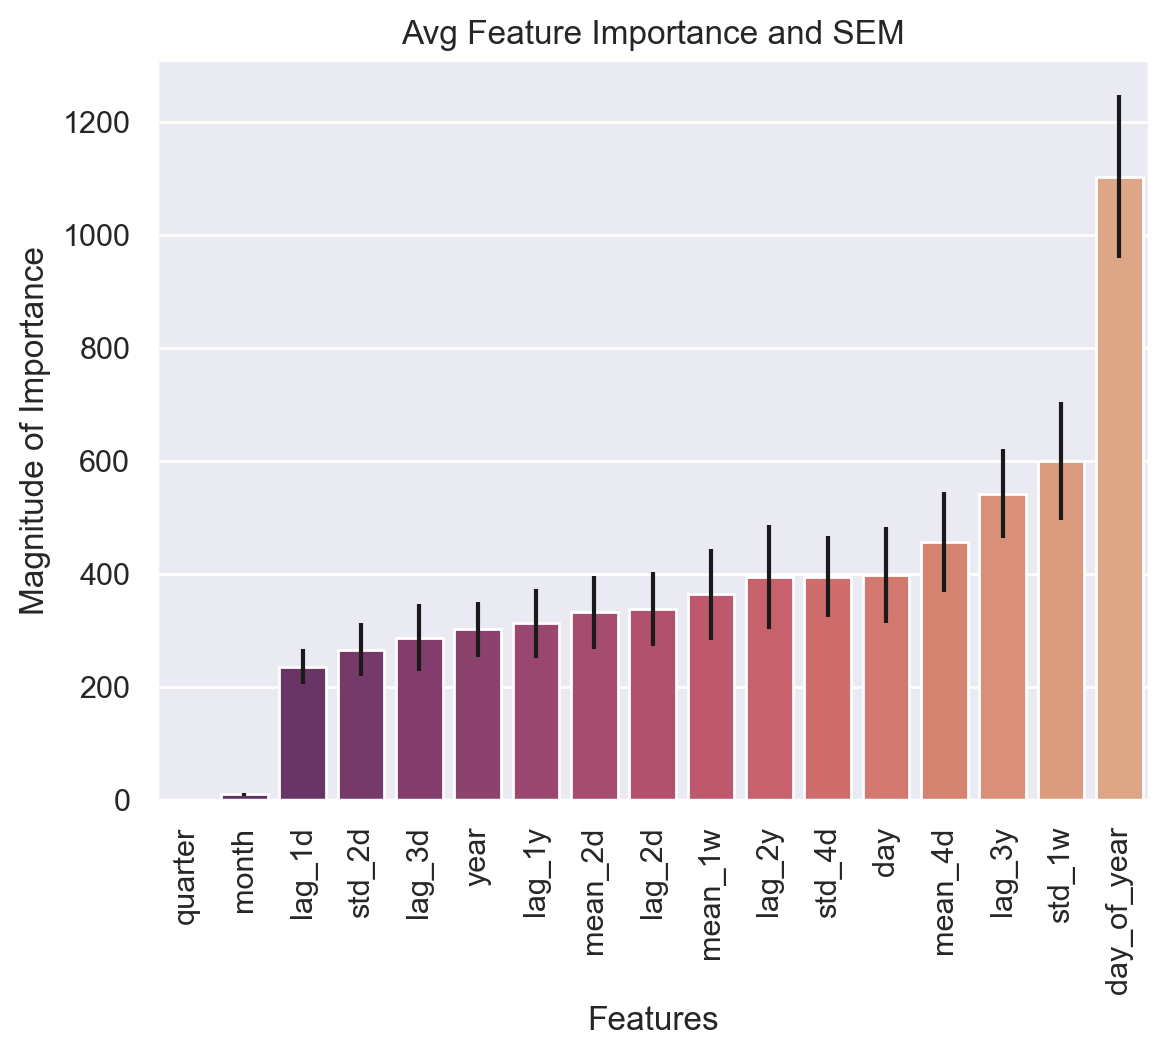

In [26]:
feature_importances_plot(fi)

<AxesSubplot: ylabel='preds'>

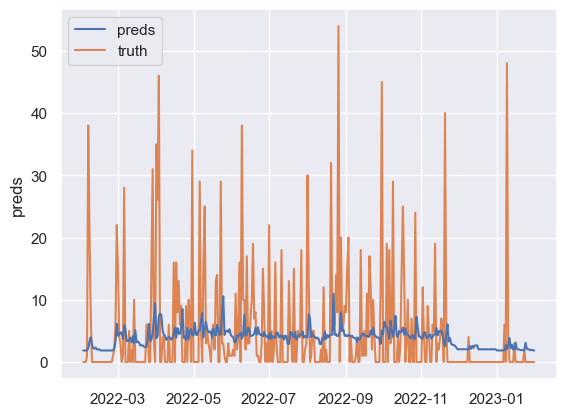

In [32]:
# fig, ax = plt.subplots()
sns.lineplot(x=df.index[oof_preds.query('fold == 4')['data_ind']], y=oof_preds.query('fold == 4')['preds'], label='preds', zorder=2)
sns.lineplot(x=df.index[oof_preds.query('fold == 4')['data_ind']], y=oof_preds.query('fold == 4')['y_true'], label='truth', zorder=1)
# oof_preds.query('fold == 0')['preds']
# oof_preds.query('fold == 0')['y_true']

In [64]:
df.groupby(['year', 'month']).agg('sum')['rain']

year  month
2006  10        22
      11       187
      12        78
2007  1         18
      2         32
              ... 
2022  9        194
      10       178
      11       127
      12         4
2023  1         63
Name: rain, Length: 196, dtype: int64

In [65]:
monthly = pd.DataFrame(data=df.groupby(['year', 'month']).agg('mean')['rain'].values, index=df.query('day == 1').index, columns=['mean_rain_mm'])

In [66]:
monthly = get_features(monthly)

In [67]:
monthly

,mean_rain_mm,day_of_year,year,month,day,quarter
2006-10-01,0.709677,274,2006,10,1,4
2006-11-01,6.233333,305,2006,11,1,4
2006-12-01,2.516129,335,2006,12,1,4
2007-01-01,0.580645,1,2007,1,1,1
2007-02-01,1.142857,32,2007,2,1,1
...,...,...,...,...,...,...
2022-09-01,6.466667,244,2022,9,1,3
2022-10-01,5.741935,274,2022,10,1,4
2022-11-01,4.233333,305,2022,11,1,4
2022-12-01,0.129032,335,2022,12,1,4


In [75]:
tss = TimeSeriesSplit(n_splits=5, test_size=12)

FEATURES = ['day_of_year', 'year', 'month', 'day', 'quarter']
TARGET = 'total_rain_mm'

models = []
oof_preds = []
scores = []
fi = []

for fold, (train_idx, test_idx) in enumerate(tss.split(monthly)):
    print('training fold', fold)
    train = monthly.iloc[train_idx]
    test = monthly.iloc[test_idx]

#     train = get_lags(train)
#     test = get_lags(test)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    eval_set = [(X_test, y_test)]

    reg = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=2000)
    reg.fit(X_train, y_train, eval_set=eval_set,
            early_stopping_rounds=50,
            verbose=100)
    
    test_preds = reg.predict(X_test)
    test_score = np.sqrt(mean_squared_error(y_test, test_preds))
    scores.append(test_score)

    idx_pred_target = np.vstack([test_idx, test_preds, y_test, fold*np.ones(len(test_idx))]).T
    oof_preds.append(idx_pred_target)

    fi.append(dict(zip(reg.feature_name_, reg.feature_importances_)))

    models.append(reg)

training fold 0


KeyError: 'total_rain_mm'

In [69]:
fi = avg_fi(fi)

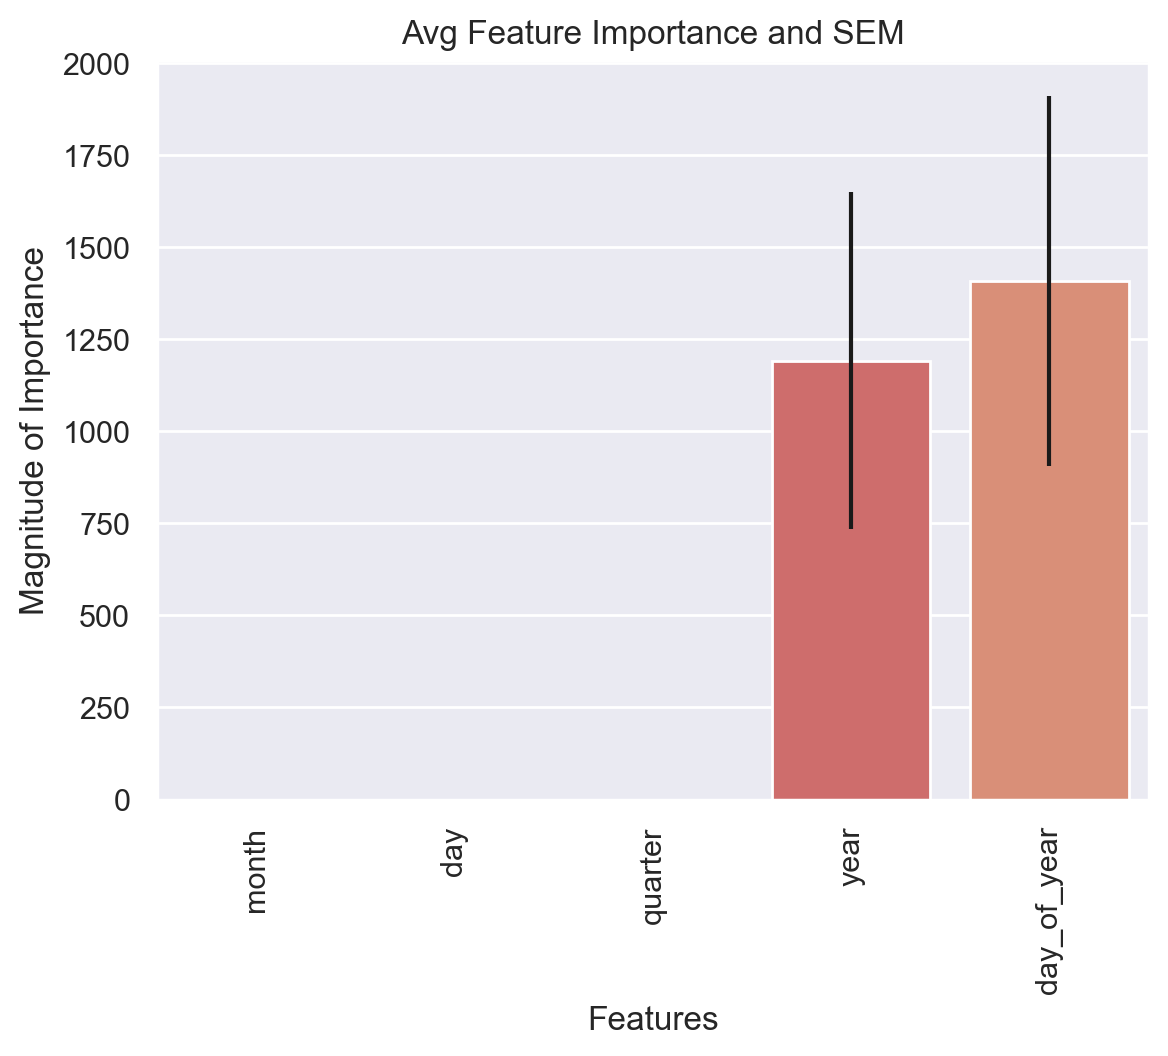

In [70]:
feature_importances_plot(fi)

In [73]:
oof_preds = pd.DataFrame(data=np.concatenate(oof_preds), columns=['data_ind', 'preds', 'y_true', 'fold'])
oof_preds['data_ind'] = oof_preds['data_ind'].astype('int32')
oof_preds['y_true'] = oof_preds['y_true'].astype('int32')
oof_preds['fold'] = oof_preds['fold'].astype('int32')

KeyError: 0

<AxesSubplot: ylabel='preds'>

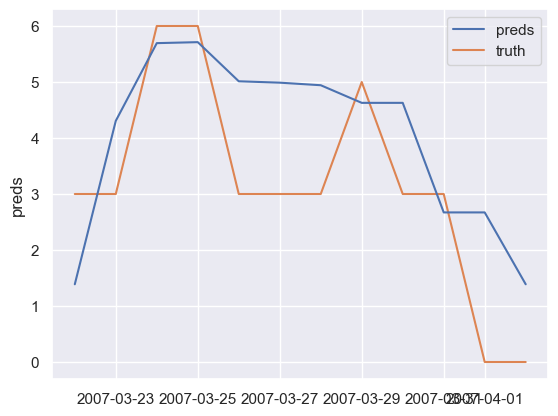

In [74]:
sns.lineplot(x=df.index[oof_preds.query('fold == 3')['data_ind']], y=oof_preds.query('fold == 3')['preds'], label='preds', zorder=2)
sns.lineplot(x=df.index[oof_preds.query('fold == 3')['data_ind']], y=oof_preds.query('fold == 3')['y_true'], label='truth', zorder=1)